# FER+ - all classes
**Author**: Johannes S. Fischer

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from datetime import datetime

In [2]:
model_name = 'FERplus-impr-v2'

Load pretrained model to fine-tune it? If yes, specify model name, if no set it to ```None```.

In [3]:
pretrained_model_name = "FERplus-impr-v2_0121-0920"

# Data

## Preprocessing Function
Preprocessing function like for VGG16, where pixel values per channel are normalized to have zero mean (```tensorflow``` implementation can be found [here](https://github.com/keras-team/keras/blob/2c48a3b38b6b6139be2da501982fd2f61d7d48fe/keras/applications/imagenet_utils.py#L168)).

In [4]:
# FERplus 2013 training data mean and std
mean = [129.4432, 129.4432, 129.4432]
std = None # [64.87448751, 64.87448751, 64.87448751]

def preprocess(x):
    # ensure image format
    x = np.array(x, dtype='float32')
    
    # normalize
    x[..., 0] -= mean[0]
    x[..., 1] -= mean[1]
    x[..., 2] -= mean[2]
    if std is not None:
        x[..., 0] /= std[0]
        x[..., 1] /= std[1]
        x[..., 2] /= std[2] 
    return x

def de_preprocess(x):
    if std is not None:
        x[..., 0] *= std[0]
        x[..., 1] *= std[1]
        x[..., 2] *= std[2]
    # normalize
    x[..., 0] += mean[0]
    x[..., 1] += mean[1]
    x[..., 2] += mean[2]
    return x.astype('uint8')

## Load Data

In [5]:
%%time

from Dataloader import load_FERplus_targetvector

# settings
DATA_DIR = './data/ferplus2013/'

IMG_SIZE = (100, 100)
IMG_SHAPE = IMG_SIZE + (3,)

BATCH_SIZE = 64

# load data
train_ds, val_ds, test_ds = load_FERplus_targetvector(DATA_DIR,
                                                      target_img_size=IMG_SIZE,
                                                      batch_size=BATCH_SIZE,
                                                      preprocessing_function=preprocess)

Training
- (28557, 100, 100, 3) 
- (28557, 7)
Validation
- (3573, 100, 100, 3) 
- (3573, 7)
Testing
- (3579, 100, 100, 3) 
- (3579, 7)
Wall time: 45.3 s


Prepare some function to get labels...

In [6]:
emotion_labels = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear']

num_classes = len(emotion_labels)
print("Number of classes: ", num_classes)

def vec2label(onehot_vec):
    major_vote = np.argmax(onehot_vec)
    return emotion_labels[major_vote]

Number of classes:  7


## Data Examples

Show some examples...

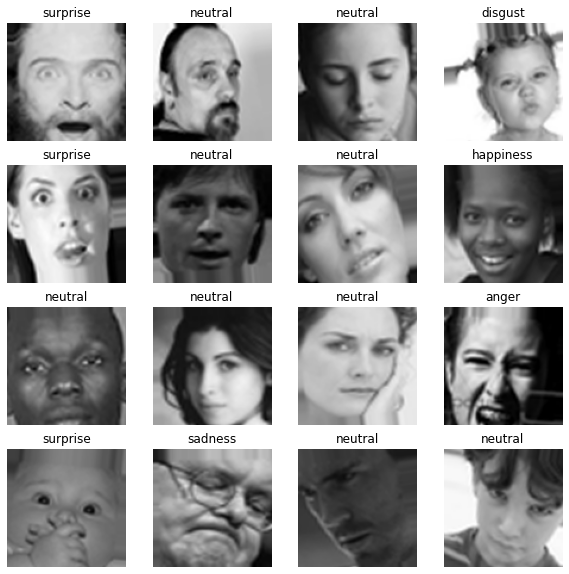

In [7]:
images, labels = next(train_ds)

plt.subplots(4,4, figsize=(10, 10))
for i in range(16):
    plt.subplot(4,4, i+1)
    plt.imshow(
        de_preprocess(images[i])
    )
    plt.title(vec2label(labels[i]))
    plt.axis('off')
plt.show()

# Model

## Base model
Architecture of the model without classification layer.

In [8]:
from ModelGenerator import get_base_model2

# get base model
model = get_base_model2(IMG_SHAPE)

## Classification model
Add classification layer to the base model.

In [9]:
# add classification layer (softmax)
model.add(tf.keras.layers.Dense(num_classes, activation='softmax', name="softmax"))

# load pretrained version if required
if pretrained_model_name is not None:
    model.load_weights(f'./models/{pretrained_model_name}')

# compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (ConvLayer)     (None, 100, 100, 64)      2048      
_________________________________________________________________
block1_conv2 (ConvLayer)     (None, 100, 100, 64)      37184     
_________________________________________________________________
maxpool_1 (MaxPooling2D)     (None, 33, 33, 64)        0         
_________________________________________________________________
block2_conv1 (ConvLayer)     (None, 33, 33, 96)        55776     
_________________________________________________________________
block2_conv2 (ConvLayer)     (None, 33, 33, 96)        83424     
_________________________________________________________________
block2_conv3 (ConvLayer)     (None, 33, 33, 96)        83424     
_________________________________________________________________
maxpool_2 (MaxPooling2D)     (None, 11, 11, 96)        0

# Training

In [10]:
# callbacks
dt = datetime.now().strftime("%m%d-%H%M")

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath=f"./modelcheckpoints/{model_name}_{dt}",
                                       monitor='val_accuracy',
                                       save_best_only=True,
                                       verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                         factor=0.1,
                                         patience=4,
                                         verbose=1,
                                         mode='auto',
                                         min_lr=0.00000001),
    tf.keras.callbacks.CSVLogger(f'./log/{model_name}_{dt}.csv',
                                 separator=",", append=True)
]

In [11]:
%%time

epochs = 20

history = model.fit(train_ds,
                    epochs=epochs,
                    validation_data=val_ds,
                    callbacks=callbacks)

Epoch 1/20
447/447 [==============================] - 106s 221ms/step - loss: 0.7047 - accuracy: 0.8819 - val_loss: 0.7576 - val_accuracy: 0.8424

Epoch 00001: val_accuracy improved from -inf to 0.84243, saving model to ./modelcheckpoints\FERplus-impr-v2_0121-1101


INFO:tensorflow:Assets written to: ./modelcheckpoints\FERplus-impr-v2_0121-1101\assets


INFO:tensorflow:Assets written to: ./modelcheckpoints\FERplus-impr-v2_0121-1101\assets


Epoch 2/20
447/447 [==============================] - 100s 223ms/step - loss: 0.7036 - accuracy: 0.8832 - val_loss: 0.7558 - val_accuracy: 0.8394

Epoch 00002: val_accuracy did not improve from 0.84243
Epoch 3/20
447/447 [==============================] - 97s 218ms/step - loss: 0.7030 - accuracy: 0.8819 - val_loss: 0.7582 - val_accuracy: 0.8416

Epoch 00003: val_accuracy did not improve from 0.84243
Epoch 4/20
447/447 [==============================] - 97s 218ms/step - loss: 0.7002 - accuracy: 0.8856 - val_loss: 0.7583 - val_accuracy: 0.8385

Epoch 00004: val_accuracy did not improve from 0.84243
Epoch 5/20
447/447 [==============================] - 98s 218ms/step - loss: 0.7000 - accuracy: 0.8868 - val_loss: 0.7581 - val_accuracy: 0.8382

Epoch 00005: val_accuracy did not improve from 0.84243
Epoch 6/20
447/447 [==============================] - 98s 219ms/step - loss: 0.6988 - accuracy: 0.8859 - val_loss: 0.7632 - val_accuracy: 0.8380

Epoch 00006: val_accuracy did not improve from 0.

INFO:tensorflow:Assets written to: ./modelcheckpoints\FERplus-impr-v2_0121-1101\assets


INFO:tensorflow:Assets written to: ./modelcheckpoints\FERplus-impr-v2_0121-1101\assets


Epoch 8/20
447/447 [==============================] - 98s 219ms/step - loss: 0.6950 - accuracy: 0.8896 - val_loss: 0.7564 - val_accuracy: 0.8413

Epoch 00008: val_accuracy did not improve from 0.84271
Epoch 9/20
447/447 [==============================] - 100s 224ms/step - loss: 0.6943 - accuracy: 0.8884 - val_loss: 0.7562 - val_accuracy: 0.8405

Epoch 00009: val_accuracy did not improve from 0.84271
Epoch 10/20
447/447 [==============================] - 101s 225ms/step - loss: 0.6942 - accuracy: 0.8882 - val_loss: 0.7565 - val_accuracy: 0.8419

Epoch 00010: val_accuracy did not improve from 0.84271

Epoch 00010: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 11/20
447/447 [==============================] - 99s 220ms/step - loss: 0.6945 - accuracy: 0.8894 - val_loss: 0.7566 - val_accuracy: 0.8419

Epoch 00011: val_accuracy did not improve from 0.84271
Epoch 12/20
447/447 [==============================] - 98s 219ms/step - loss: 0.6954 - accuracy: 0.8875 - val_

INFO:tensorflow:Assets written to: ./modelcheckpoints\FERplus-impr-v2_0121-1101\assets


INFO:tensorflow:Assets written to: ./modelcheckpoints\FERplus-impr-v2_0121-1101\assets


Epoch 13/20
447/447 [==============================] - 125s 280ms/step - loss: 0.6936 - accuracy: 0.8893 - val_loss: 0.7563 - val_accuracy: 0.8402

Epoch 00013: val_accuracy did not improve from 0.84299
Epoch 14/20
447/447 [==============================] - 107s 239ms/step - loss: 0.6945 - accuracy: 0.8877 - val_loss: 0.7563 - val_accuracy: 0.8413

Epoch 00014: val_accuracy did not improve from 0.84299

Epoch 00014: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
Epoch 15/20
447/447 [==============================] - 113s 253ms/step - loss: 0.6951 - accuracy: 0.8886 - val_loss: 0.7563 - val_accuracy: 0.8413

Epoch 00015: val_accuracy did not improve from 0.84299
Epoch 16/20
447/447 [==============================] - 109s 243ms/step - loss: 0.6940 - accuracy: 0.8858 - val_loss: 0.7565 - val_accuracy: 0.8421

Epoch 00016: val_accuracy did not improve from 0.84299
Epoch 17/20
447/447 [==============================] - 104s 233ms/step - loss: 0.6947 - accuracy: 0.8871 -

# Results

## Training Results

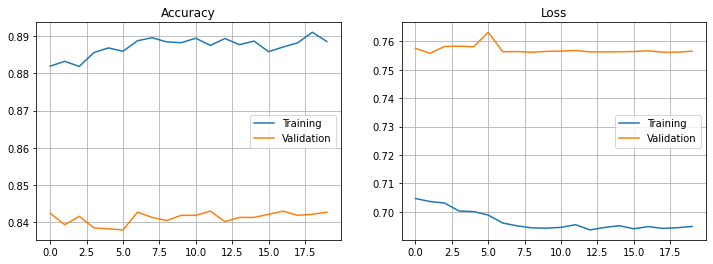

In [12]:
plt.figure(figsize=(12, 4))
# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title("Accuracy")
plt.grid(); plt.legend()
# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("Loss")
plt.grid(); plt.legend()
plt.show()

## Test Results

In [13]:
loss, acc = model.evaluate(test_ds, verbose=2)

print("\nAccuracy:\t%.2f%%" % (acc * 100))
print("Loss:\t\t%.4f" % (loss))

56/56 - 5s - loss: 0.7129 - accuracy: 0.8494

Accuracy:	84.94%
Loss:		0.7129


# Save Model

In [14]:
if True:
    model.save_weights('./models/' + model_name + "_" + dt + '_weights.h5')
    model.save("./models/" + model_name + "_" + dt + "/")
    f = open("./models/info.txt", "a")
    txt = model_name + "_" + dt + " = " + str(np.max(history.history['val_accuracy'])*100) + "\n"
    f.write(txt)
    f.close()

INFO:tensorflow:Assets written to: ./models/FERplus-impr-v2_0121-1101/assets


INFO:tensorflow:Assets written to: ./models/FERplus-impr-v2_0121-1101/assets


---